<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loader" data-toc-modified-id="Data-loader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loader</a></span></li></ul></div>

# Подключение библиотек

In [8]:
import pandas as pd
import json
import torch
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

## Data loader

In [2]:
class PlanesDataset(Dataset):
    
    def __init__(self, annotation_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_json(annotation_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,idx + '.jpg')
        image = io.imread(img_name)
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        #sample = {'image': image, 'landmarks': landmarks}
        return image

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
planes_dataset = PlanesDataset(annotation_file='/home/alex/Рабочий стол/python/yandex/planes/labels.json',
                                    root_dir='/home/alex/Рабочий стол/python/yandex/planes/data/')


In [5]:
image = planes_dataset['26']

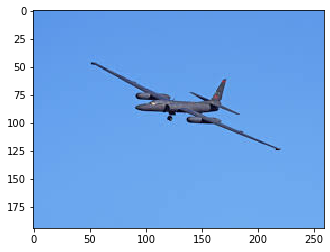

In [6]:
plt.imshow(image)
plt.show()

In [16]:
with open('/home/alex/Рабочий стол/python/yandex/planes/labels.json') as json_file:
    data = json.load(json_file)
    print(data)

[{'id': 109, 'annotations': [{'id': 109, 'completed_by': {'id': 1, 'email': 'chulgarev@gmail.com', 'first_name': '', 'last_name': ''}, 'state': {}, 'result': [{'original_width': 284, 'original_height': 177, 'image_rotation': 0, 'value': {'x': 6.814833090338908, 'y': 18.64406779661017, 'width': 87.90347676881602, 'height': 50.847457627118644, 'rotation': 0, 'rectanglelabels': ['plane']}, 'id': 'C40DQ05qd_', 'from_name': 'label', 'to_name': 'image', 'type': 'rectanglelabels'}], 'was_cancelled': False, 'ground_truth': False, 'created_at': '2021-04-11T16:03:28.257487Z', 'updated_at': '2021-04-11T16:03:41.837545Z', 'lead_time': 11901.012, 'prediction': {}, 'result_count': 0, 'task': 109}], 'predictions': [], 'file_upload': '108.jpeg', 'data': {'image': '/data/upload/108.jpeg'}, 'meta': {}, 'created_at': '2021-04-11T12:37:38.531583Z', 'updated_at': '2021-04-11T16:03:41.820904Z', 'project': 1}, {'id': 105, 'annotations': [{'id': 105, 'completed_by': {'id': 1, 'email': 'chulgarev@gmail.com', '

In [40]:
for i in data:
    print(i['data']['image'])
    print(i['annotations'][0]['result'][0]['value'])
    break

/data/upload/108.jpeg
{'x': 6.814833090338908, 'y': 18.64406779661017, 'width': 87.90347676881602, 'height': 50.847457627118644, 'rotation': 0, 'rectanglelabels': ['plane']}
